The difference in this notebook with the other is it uses a custom noise model, as intented in the challenge.

ℹ️ ℹ️ ℹ️ Readers can modify the `circuit` variable of cell 1 to switch between implemented circuits and run the Notebook as is ℹ️ ℹ️ ℹ️

In [1]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 600
plt.rcParams['savefig.dpi'] = 600

import pennylane as qml
import pennylane.numpy as np
import pandas as pd

import util

# ⚠️⚠️⚠️ change this ⚠️⚠️⚠️
circuit = util.circuit_bell_state_noisy   # options [util.circuit_bell_state_noisy, 
                                           #          util.circuit_hamiltonian_noisy]


SIMULATION_MODE = True    # running from local or real hardware
noise_strengths = np.linspace(0.0,0.75,11)
scale_factors = range(4,7)   # at least 4 for exponential extrapolation, due to range of python doesn't include the last element, starting from 3 means the list of scale factors will be range(1,3) = [1,2]
ibmqx_token="xxx"

In [2]:
if circuit == util.circuit_bell_state_noisy:
    wires = 2
elif circuit == util.circuit_hamiltonian_noisy:
    wires = 2
else:
    raise ValueError("Unsupported circuit")

##  Build a simple noise model with depolarizing noise

In [3]:
if SIMULATION_MODE:
    dev = qml.device("default.mixed", wires=wires)    
else:
    dev = qml.device('qiskit.ibmq', wires=wires, 
                     backend='ibm_kyoto', ibmqx_token=ibmqx_token)
noise_less_dev = qml.device("default.qubit", wires=wires)

## Apply folding method and different extrapolation

We define `results` dataframe to save our experiments. It will have the structure like this

|    |   scale_factor |   noise_strength | extrapolation_type   |    value |
|---:|---------------:|-----------------:|:---------------------|---------:|
|  0 |              1 |              0.1 | linear               | 0.375556 |
|  1 |              1 |              0.1 | polynomial           | 0.375556 |
|  2 |              1 |              0.1 | reference_polynomial | 0.375556 |



In [4]:
dict_list = []
for noise_lvl in noise_strengths:   # noise level loop    
    device_circuit = qml.QNode(circuit, dev)
    for max_scale_factor in scale_factors:   # max scale factor loop
        # unitary folding
        result_per_noise_level = []
        for scale_factor in range(1, max_scale_factor):   # loop from 1 to current max scale factor
            ops, measurements = util.unitary_fold(device_circuit, scale_factor, noise_lvl)
            folded_circuit = util.circuit_from_ops(dev, ops, measurements)
            result_per_noise_level.append(float(folded_circuit))
        # done unitary folding

        # without zne
        dict_list.append(util.create_record('non_zne', noise_lvl, max_scale_factor, device_circuit(noise_lvl)))
        
        # extrapolation with the scale factors up to i_scale+1 and current result_per_noise_level        
        dict_list.append(util.create_record('linear', noise_lvl, max_scale_factor,
                      float(util.linear_extrapolation(range(1, max_scale_factor), result_per_noise_level))))
        #dict_list.append(util.create_record('exp', noise_lvl, max_scale_factor,
        #                 float(util.exponential_extrapolation(range(1, max_scale_factor), result_per_noise_level))))
        dict_list.append(util.create_record('polynomial', noise_lvl, max_scale_factor,
                        float(util.polynomial_extrapolation(range(1, max_scale_factor), result_per_noise_level, max_scale_factor-2))))  # scale_factor is in range(1, scale_factor), so its max value is scale_factor-1. Now we -1 once more because of the math in polynomial extrapolation

In [5]:
results = pd.DataFrame(dict_list)

## Research questions

Given a circuit and the noise stregth, it is interesting to see how many fold and which  method to use. To answer that we would plot the `results` dataframe

In [6]:
results['noise_strength'] = results['noise_strength'].astype(float)
results['value'] = results['value'].astype(float)

In [7]:
line_style_plot = {
    'non_zne': ':',
    'reference_linear': '--',
    'reference_exp': '--',
    'reference_polynomial': '--',
    'polynomial': '-',
    'linear': '-',
    'exp': '-'
}

linewidth_plot = {
    'non_zne': 5,    
    'reference_linear': 5,
    'reference_exp': 5,    
    'reference_polynomial': 5,
    'polynomial': 1,
    'linear': 1,
    'exp': 1
}

alpha_plot = {
    'non_zne': 1,
    'reference_linear': 0.2,
    'reference_exp': 0.2,
    'reference_polynomial': 0.2,
    'polynomial': 1,
    'linear': 1,
    'exp': 1    
}

color_plot = {
    'non_zne': 'orange',
    'reference_linear': 'green',
    'reference_exp': 'blue',
    'reference_polynomial': 'red',
    'polynomial': 'red',
    'linear': 'green',
    'exp': 'blue'
}

In [8]:
ideal_result = list(set(results[results["noise_strength"]==0]['value']))[0]

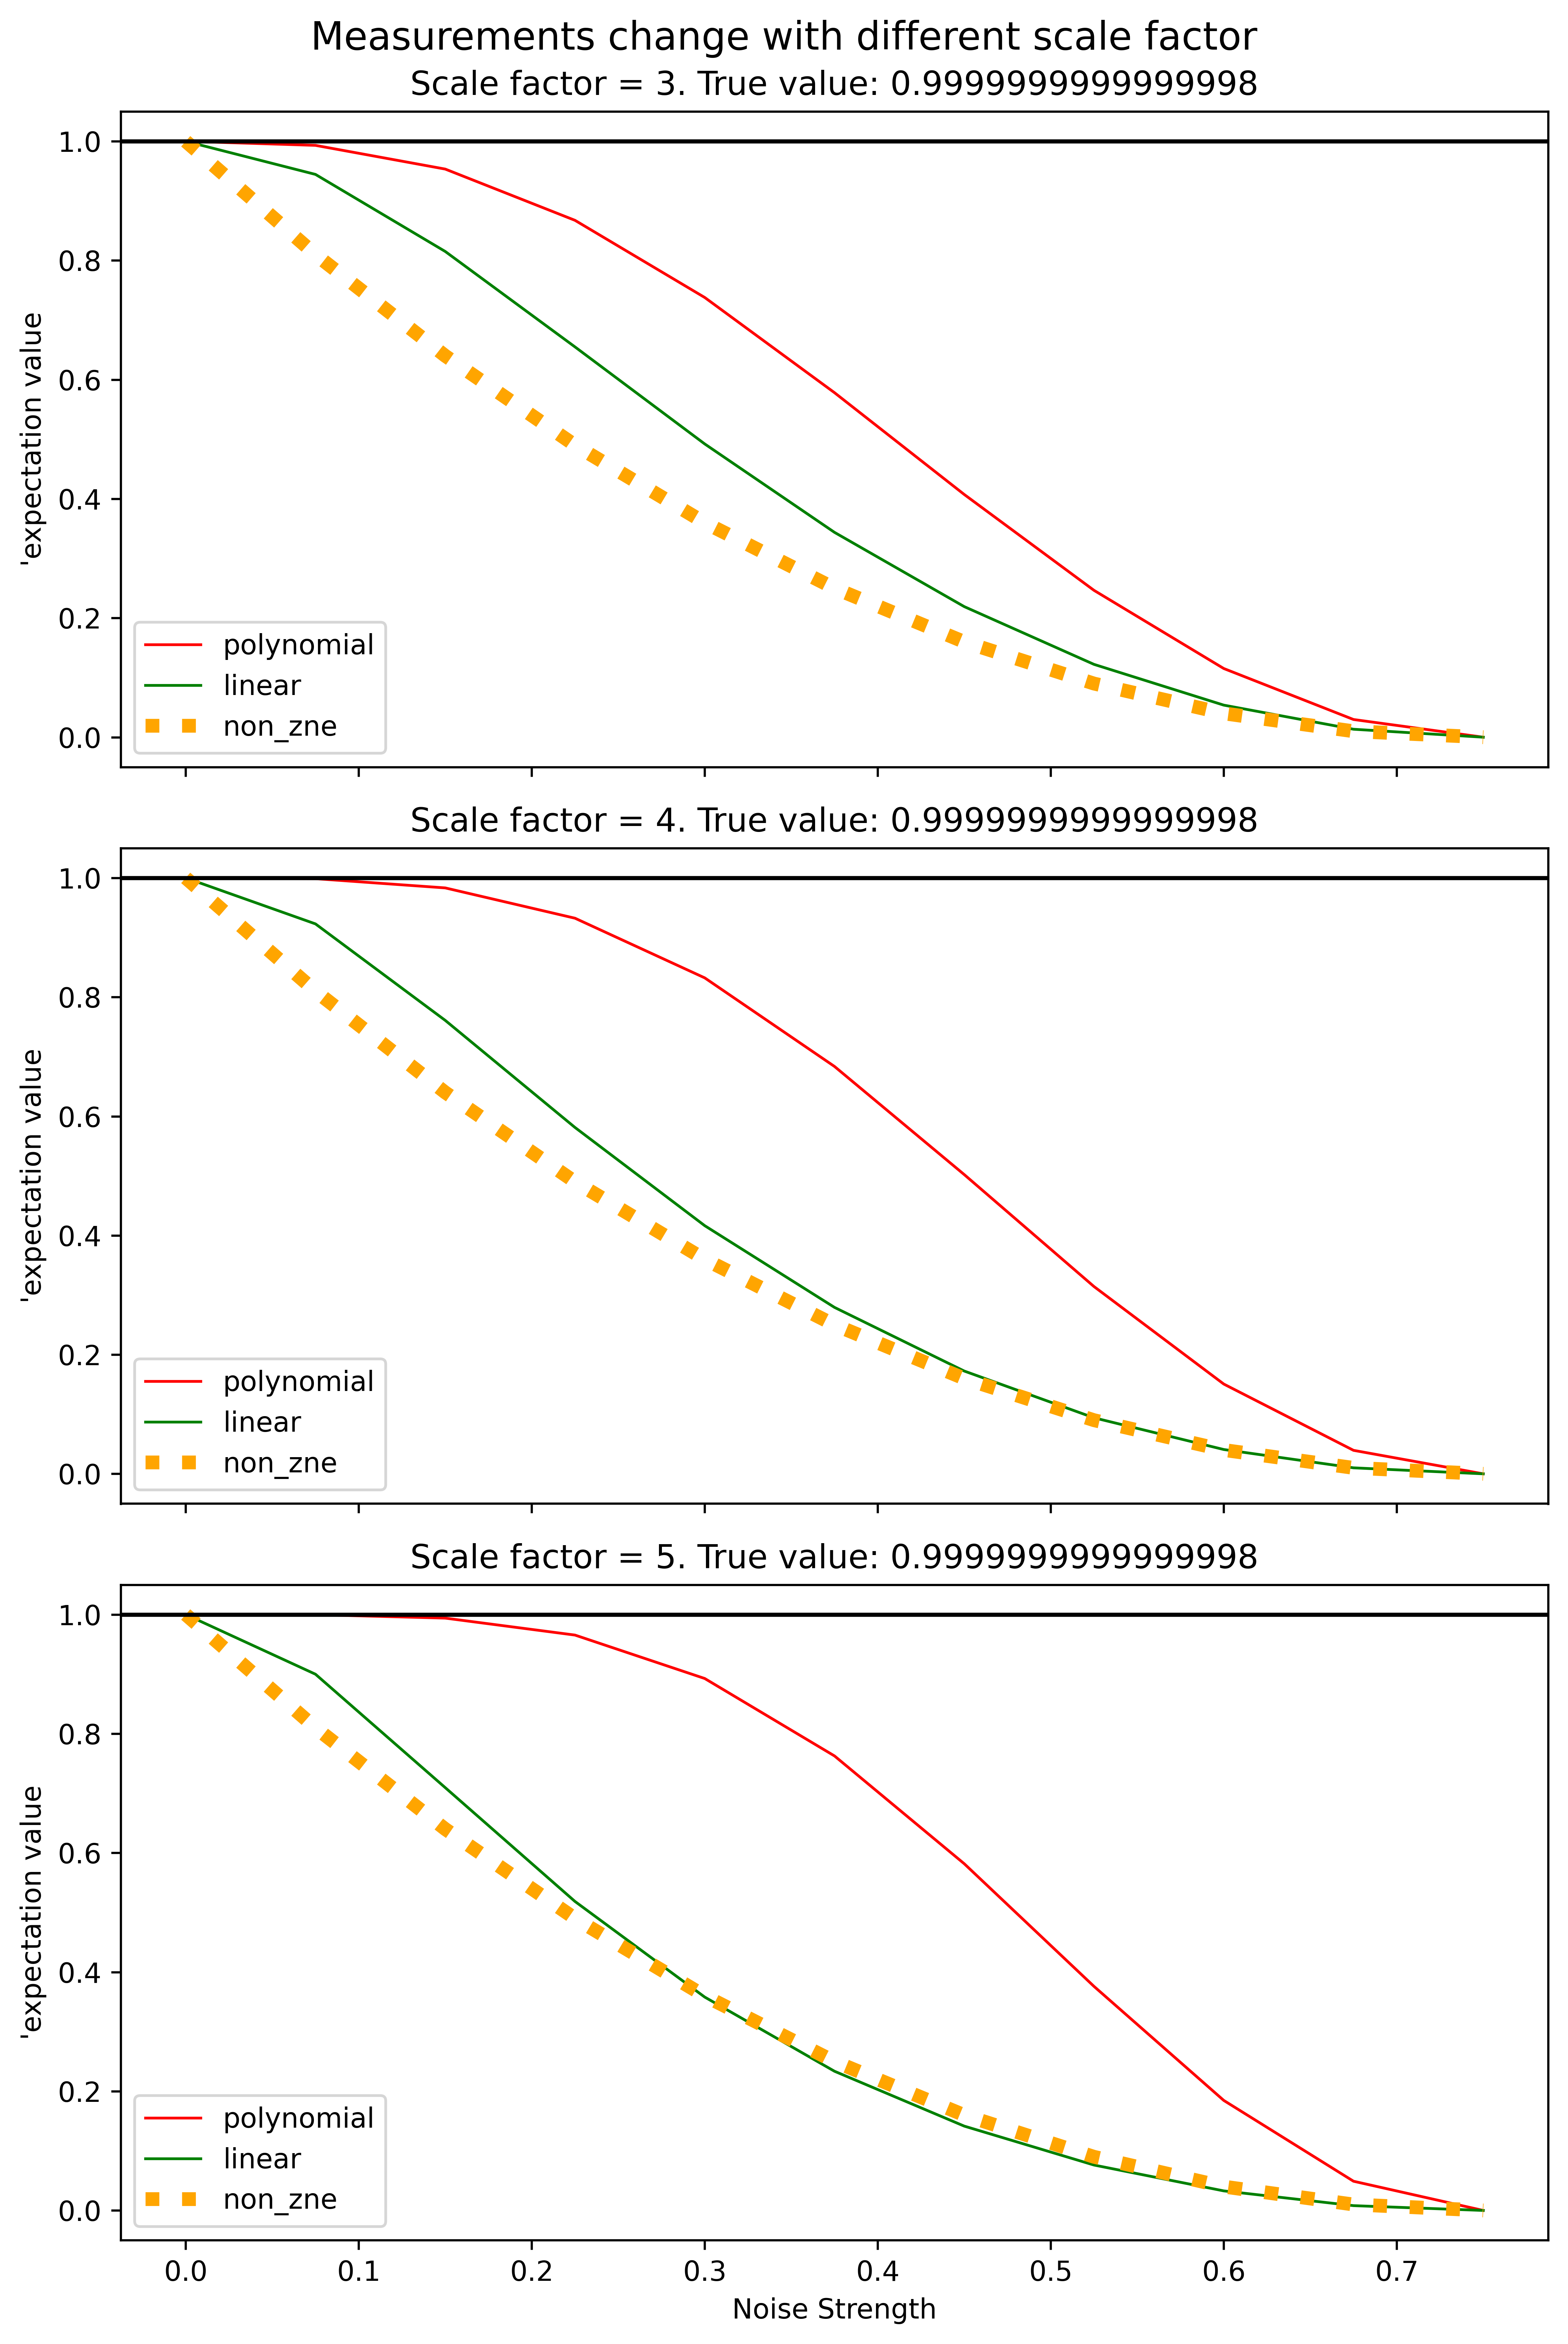

In [9]:
fig, axs = plt.subplots(nrows=len(scale_factors), ncols=1, sharex=True)

# Plot data for each 'extrapolation_type'
for s_factor_index, s_factor in enumerate(scale_factors):
    for extrapolation_type in set(results['extrapolation_type']):
        df = results[(results['extrapolation_type'] == extrapolation_type) & (results["scale_factor"] == s_factor)]
        df.plot(x='noise_strength', y='value', figsize=(8, 12), ax=axs[s_factor_index], 
                label=extrapolation_type, linestyle=line_style_plot[extrapolation_type],
                linewidth=linewidth_plot[extrapolation_type], alpha=alpha_plot[extrapolation_type],
                color=color_plot[extrapolation_type],
               )    
    axs[s_factor_index].axhline(y = ideal_result, color = 'black', linestyle = '-', label="Zero noise result") 
    axs[s_factor_index].set_title(f'Scale factor = {s_factor-1}. True value: {ideal_result}')
    axs[s_factor_index].xaxis.set_major_formatter(plt.FormatStrFormatter("%.1f"))
    axs[s_factor_index].set_ylabel("'expectation value")
    

plt.xlabel("Noise Strength")
fig.suptitle("Measurements change with different scale factor", fontsize=14)
plt.tight_layout()

plt.show()

We can calculate the Mean square error of different methods. However, just by visually inspecting these charts, we can see that for polynomial extrapolation (PE), higher scale factors is only good for the higher noise strength (to the right of the $x$ axis). That being said, PE tends to overestimate the expectation value in low noise and too high scale factors.

The linear extrapolation is quite stable, as one can predicts the performance given the noise strength. It is only slightly better than without zero noise extrapolation.